In [ ]:
#!/usr/bin/python
# find . -name '.DS_Store' -type f -delete
# Chulwoo Pack

import sys
import os
from page import Page

SHOW_STEPS = True    # change this to false if you just want to see the final output for each page.
SAVE_OUTPUT = True
SAVE_DOCSTRUM = True

inputFolder = os.path.join('images')
outputFolder = os.path.join('output')

    
inputPath = os.path.join(inputFolder, os.listdir(inputFolder)[0])
outputPath = os.path.join(outputFolder, os.listdir(inputFolder)[0])

page = Page(inputPath, SHOW_STEPS, SAVE_DOCSTRUM)
#page = Page(inputPath, SHOW_STEPS)
    
if SAVE_OUTPUT:
    page.save(outputPath)  # save a copy of what is displayed. Used for getting images for the paper.
    
page.show((800, 800))

0.00	0.00	images/WO2_B0001ORIWEEJO_1718_01_04-0001.jpg
Total  6536  characters are found.
0.62	0.62	got characters
('average NN distance: ', 12.763877920620036)
('average NN horizontal distance: ', 16.91307671239138)
('average NN vertical distance: ', 20.239550725504277)
5.47	4.85	got words & tuples
Total  2916  words are found.


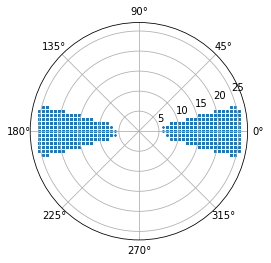

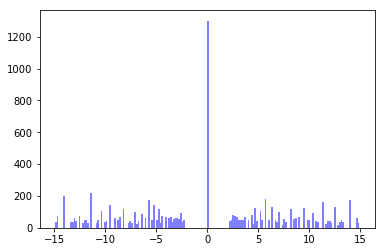

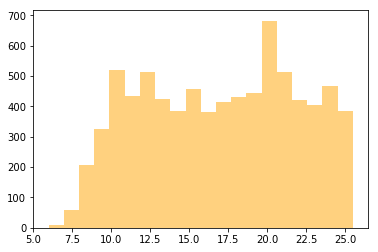

6.58	1.11	built Docstrum
6.58	0.00	finished analysing page
average time: 6.58

2916
2916


In [1]:
# LINE EXTRACTION TESTING

import sys
import os
from page import Page

import cv2
import math
import numpy
import subprocess
import os

import colors
import geometry as g
from box import Box
import text
from dimension import Dimension
from stopwatch import Stopwatch
import numpy
import matplotlib.pyplot as plt
import ntpath


SHOW_STEPS = True    # change this to false if you just want to see the final output for each page.
SAVE_OUTPUT = True
SAVE_DOCSTRUM = False

inputFolder = os.path.join('images')
outputFolder = os.path.join('output')

    
inputPath = os.path.join(inputFolder, os.listdir(inputFolder)[0])
outputPath = os.path.join(outputFolder, os.listdir(inputFolder)[0])

page = Page(inputPath, SHOW_STEPS, SAVE_DOCSTRUM)


if True:
    page.save(outputPath)  # save a copy of what is displayed. Used for getting images for the paper.
    
page.show((800, 800))

In [2]:
# Backup lines.. remove this later..
my_backup_lines = page.lines

In [3]:
#NER VERSION: ADJUSTIVE SEARCHING ORDER
import cv2

from shapely.geometry import Point            # For checking overlap
from shapely.geometry.polygon import Polygon  # For checking overlap
from shapely.geometry import MultiPoint       # For checking overlap

image = page.image.copy()

EPS = 1e-10
group_idx = 0
threshold_angle = 1.0
threshold_paralldist = 2.1 * 17.0
threshold_perpendist = 1.9 * 25.0
threshold_overlap    = 1.0
threshold_early_skip = 30

SHOW_DETAIL      = False
SHOW_VISUAL_STEP = False
EARLY_SKIP       = False

########
# INIT #
########
# Get lines
#my_lines  = page.lines
my_lines = my_backup_lines # remove this later when test is done, and use the above line
# Sorting lines
my_lines.sort(key=lambda line:((line.start.y+line.end.y)/2,(line.start.x+line.end.x)/2))
# Lines assigned a group
my_lines_in_group = []
# Lines not assigned any group yet
my_lines_no_group = []
for i in range(0,len(my_lines)-1):
    my_lines_no_group.append(i)
if SHOW_DETAIL: print("no_group:",my_lines_in_group)
if SHOW_DETAIL: print("in_group:",my_lines_no_group)
# First line, not dot (its index, i)

while(True): # Make sure looked up every lines
    #flag_found_none = True
    if ((len(my_lines_in_group) == 0) and (len(my_lines_no_group) == 0)):
        break
    #######################
    # Set the ith element #
    #######################
    i = -1
    if EARLY_SKIP:
        early_skip = threshold_early_skip
    ## TODO: Since, currently there is no lines in my_lines_in_group queue and lines are remained, find another line as ith element in my_lines_no_group queue with excluding dots. 
    if(len(my_lines_in_group) == 0):
        delta_x_i = 0
        delta_y_i = 0
        for candidate_line_idx in my_lines_no_group[:]:
            x_O_i = my_lines[candidate_line_idx].start.x
            y_O_i = page.image.shape[0] - my_lines[candidate_line_idx].start.y
            x_F_i = my_lines[candidate_line_idx].end.x
            y_F_i = page.image.shape[0] - my_lines[candidate_line_idx].end.y 
            #delta_x_i = abs(x_F_i - x_O_i)
            delta_x_i = float(x_F_i - x_O_i)
            #delta_y_i = abs(y_F_i - y_O_i)
            delta_y_i = float(y_F_i - y_O_i)
            if (delta_x_i != 0 and delta_y_i != 0): # Found!
                i = candidate_line_idx
                my_lines_no_group.remove(candidate_line_idx)
                break
    else:
        i = my_lines_in_group.pop(0)
    # TODO: more sophisticated way to break?
    if (i == -1):
        break
    
    # Visualize ith element
    if SHOW_VISUAL_STEP:
        image = page.image.copy()
        cv2.line(image, ((my_lines[i].start.x,my_lines[i].start.y)),((my_lines[i].end.x,my_lines[i].end.y)), (0,0,255),30)
        imS = cv2.resize(image, (800, 800))
        cv2.imshow('Show Steps: new i', imS)
        cv2.waitKey()
                                                                
    # No more lines to search
    if (len(my_lines_no_group) == 0):
        break
    else:
        #######################
        # Set the jth element #
        #######################
        for j in my_lines_no_group[:]:
            if EARLY_SKIP:
                if early_skip < 0:
                    break
            if SHOW_VISUAL_STEP:
                cv2.line(image, ((my_lines[j].start.x,my_lines[j].start.y)),((my_lines[j].end.x,my_lines[j].end.y)), (255,0,0),30)
                imS = cv2.resize(image, (800, 800))
                cv2.imshow('Show Steps: new i', imS)
                cv2.waitKey()

            sameGroup = False
            ################################
            # CALCULATE GEOMETRIC FEATURES #
            ################################
            # Point setting
            x_O_i = my_lines[i].start.x
            y_O_i = page.image.shape[0] - my_lines[i].start.y
            x_F_i = my_lines[i].end.x
            y_F_i = page.image.shape[0] - my_lines[i].end.y 

            x_O_j = my_lines[j].start.x
            y_O_j = page.image.shape[0] - my_lines[j].start.y
            x_F_j = my_lines[j].end.x
            y_F_j = page.image.shape[0] - my_lines[j].end.y

            #delta_x_i = abs(x_F_i - x_O_i)
            #delta_y_i = abs(y_F_i - y_O_i)
            #delta_x_j = abs(x_F_j - x_O_j)
            #delta_y_j = abs(y_F_j - y_O_j)
            delta_x_i = float(x_F_i - x_O_i)
            delta_y_i = float(y_F_i - y_O_i)
            delta_x_j = float(x_F_j - x_O_j)
            delta_y_j = float(y_F_j - y_O_j)
            
            
            # ith or jth line is dot, so skip it
            if (delta_x_j == 0 and delta_y_j == 0):
                my_lines_no_group.remove(j)
                continue

            if SHOW_DETAIL:
                print("\n****************************************************************")
                print("# of in_group:",len(my_lines_in_group),my_lines_in_group)
                print("# of no_group:",len(my_lines_no_group),my_lines_no_group)
                print(i, my_lines[i].points)
                print(j, my_lines[j].points)
                print("i:",x_O_i,y_O_i,"-",x_F_i,y_F_i)
                print("j:",x_O_j,y_O_j,"-",x_F_j,y_F_j)

            # Calculate angle
            theta_i_j = math.atan2(delta_y_j,delta_x_j-math.atan2(delta_y_i,delta_x_i))
            if SHOW_DETAIL:
                print("Angle:",theta_i_j)

            # Calculate overlap
            #if delta_x_j == 0:
            #    delta_x_j = 0.1
            #if delta_y_i == 0:
            #    delta_y_i = 0.1
            #if delta_y_j == 0:
            #    delta_y_j = 0.1
            #if delta_x_i == 0:
            #    delta_x_i = 0.1


            x_A_j = (x_O_i*delta_x_i*delta_x_j + x_O_j*delta_y_i*delta_y_j + delta_x_j*delta_y_i*(y_O_i-y_O_j))/(delta_y_i*delta_y_j + delta_x_i*delta_x_j + EPS)
            if (delta_x_j != 0):
                y_A_j = (delta_y_j/delta_x_j)*(x_A_j - x_O_j) + y_O_j
            else:
                x_A_j = y_O_j

            x_B_j = (x_F_i*delta_x_i*delta_x_j + x_F_j*delta_y_i*delta_y_j + delta_x_j*delta_y_i*(y_F_i-y_F_j))/(delta_y_i*delta_y_j + delta_x_i*delta_x_j + EPS)
            if (delta_x_j != 0):
                y_B_j = (delta_y_j/delta_x_j)*(x_B_j - x_F_j) + y_F_j
            else:
                x_B_j = y_F_j

            # Find C and D ponts
            #x_middle_candidates = [x_O_j, x_F_j, x_A_j, x_B_j]
            #x_middle_candidates.sort()
            #y_middle_candidates = [y_O_j, y_F_j, y_A_j, y_B_j]
            #y_middle_candidates.sort()
            C_D_candidates = [(x_O_j,y_O_j), (x_F_j,y_F_j), (x_A_j,y_A_j), (x_B_j,y_B_j)]
            if (delta_x_j != 0):
                C_D_candidates.sort(key=lambda x:x[0]) # sort by x
            elif (delta_y_j != 0):
                C_D_candidates.sort(key=lambda x:x[1]) # sort by y
            x_C_j,y_C_j = C_D_candidates[1]
            x_D_j,y_D_j = C_D_candidates[2]

            if SHOW_DETAIL:
                print("x_A_j,y_A_j",x_A_j,y_A_j)
                print("x_B_j,y_B_j",x_B_j,y_B_j)
                print("x_C_j,y_C_j",x_C_j,y_C_j)
                print("x_D_j,y_D_j",x_D_j,y_D_j)

            #x_i_j_components = [int(x_O_i), int(x_F_i), int(x_O_j), int(x_F_j)]
            #x_i_j_components.sort()
            #y_i_j_components = [int(y_O_i), int(y_F_i), int(y_O_j), int(y_F_j)]
            #y_i_j_components.sort()
            # convert to int in order to allow generous overlap
            #if ((int(x_O_j) <= int(x_C_j) <= int(x_F_j) and (int(y_O_j) <= int(y_C_j) <= int(y_F_j) or int(y_F_j) <= int(y_C_j) <= int(y_O_j))) or (int(x_O_i) <= int(x_C_j) <= int(x_F_i) and (int(y_O_i) <= int(x_C_j) <= int(y_F_i) or int(y_F_i) <= int(y_C_j) <= int(y_O_i)))) and ((int(x_O_j) <= int(x_D_j) <= int(x_F_j) and (int(y_O_j) <= int(y_D_j) <= int(y_F_j) or int(y_F_j) <= int(y_D_j) <= int(y_O_j))) or (int(x_O_i) <= int(x_D_j) <= int(x_F_i) and (int(y_O_i) <= int(y_D_j) <= int(y_F_i) or int(y_F_i) <= int(y_D_j) <= int(y_O_i)))):
            #if ((x_i_j_components[0] <= int(x_C_j[0]) <= x_i_j_components[-1]) and (y_i_j_components[0] <= int(y_C_j) <= y_i_j_components[-1]) and (x_i_j_components[0] <= int(x_D_j) <= x_i_j_components[-1]) and (y_i_j_components[0] <= int(y_D_j) <= y_i_j_components[-1])):
            #convex_hull = MultiPoint([(x_O_j, y_O_j), (x_O_j, y_F_j), (x_F_j, y_F_j), (x_F_j, y_O_j)])
            #polygon = Polygon([(x_O_i, y_O_i), (x_F_i, y_F_i),(x_F_j, y_F_j), (x_O_j, y_O_j)])
            #convex_hull = MultiPoint([(x_O_i, y_O_i), (x_F_i, y_F_i),(x_F_j, y_F_j), (x_O_j, y_O_j)]).convex_hull
            polygon = Polygon([(x_O_j, y_O_j), (x_O_j, y_F_j), (x_F_j, y_F_j), (x_F_j, y_O_j)])
            C_point = Point(x_C_j, y_C_j)
            D_point = Point(x_D_j, y_D_j)
            #if polygon.area != convex_hull.area:
            #    overlap = False
            #elif (convex_hull.contains(C_point) and convex_hull.contains(D_point)):
            #if (convex_hull.contains(C_point) and convex_hull.contains(D_point)):
            if (polygon.contains(C_point) or polygon.touches(C_point)) and (polygon.contains(D_point) or polygon.touches(D_point)):
                overlap = True
            else:
                overlap = False
            
            #p_j = (math.sqrt(math.pow(y_D_j-y_C_j,2)+math.pow(x_D_j-x_C_j,2)))/2.0
            p_j = math.sqrt(math.pow(y_D_j-y_C_j,2)+math.pow(x_D_j-x_C_j,2))
            l_j = math.sqrt(math.pow(y_F_j-y_O_j,2)+math.pow(x_F_j-x_O_j,2))
            if (l_j == 0):
                l_j = 0.1
            if overlap:
                p_i_j = p_j/l_j
            else:
                p_i_j = -p_j/l_j

            if SHOW_DETAIL:
                print("Overlap?",overlap)
                print("p_j:",p_j)
                print("p_i_j:",p_i_j)

            # Calculate parallel_dist
            if overlap:
                d_i_j_a = p_j
            else:
                d_i_j_a = -p_j
            if SHOW_DETAIL:
                print("parallel_dist: ",d_i_j_a)

            # Calculate perpend_dist
            x_M_j = (x_C_j + x_D_j)/2.0
            y_M_j = (y_C_j + y_D_j)/2.0
            if SHOW_DETAIL:
                print("x_M_j,y_M_j",x_M_j,y_M_j)
                print("delta_x_i:",delta_x_i)
                print("delta_y_i:",delta_y_i)
                print("delta_x_j:",delta_x_j)
                print("delta_y_j:",delta_y_j)

            if delta_x_i != 0.0 and delta_y_i != 0.0:
                d_e_i_j = ((x_M_j - x_O_i) - (y_M_j - y_O_i)*delta_x_i/(delta_y_i + EPS))/((delta_x_i**2)/(delta_y_i**2 + EPS) + 1)**0.5 
            elif delta_y_i == 0.0:
                d_e_i_j = int(y_M_j) - int(y_O_i)
            elif delta_x_i == 0.0:
                d_e_i_j = int(x_M_j) - int(x_O_i)
            d_e_i_j = abs(d_e_i_j)

            if SHOW_DETAIL:
                print("perpend_dist: ",d_e_i_j)

            ######################
            # DECIDING GROUPNESS #
            #######################
            # 1. angle check
            if theta_i_j < threshold_angle:
                if SHOW_DETAIL: print("... Angle ok!")
            # 2. perpend_dist check
                if 0 < d_e_i_j < threshold_perpendist:
                    if SHOW_DETAIL: print("... Perpendicular ok!")
            # 3.a. overlap check
            # 3.b. parallel_dist check
                    if ((overlap and p_i_j <= threshold_overlap)):
                        if SHOW_DETAIL: print("... Overlap & p_i_j ok!")
                        # Group!
                        sameGroup = True
                    elif (abs(d_i_j_a) < threshold_paralldist):
                        if SHOW_DETAIL: print("... Parallel ok!")
                        # Group!
                        sameGroup = True

            if SHOW_DETAIL:
                print("same group? ",sameGroup)
            if sameGroup:
                if EARLY_SKIP:
                    early_skip = threshold_early_skip
                if SHOW_DETAIL:
                    print("before group idx: ",group_idx)
                    print("before i's group: ", my_lines[i].group)
                    print("before j's group: ", my_lines[j].group)
                if (my_lines[i].group == None) and (my_lines[j].group == None):
                    if SHOW_DETAIL:
                        print("... case 1")
                    # Assign to a new block
                    group_idx = group_idx + 1
                    my_lines[i].group = group_idx
                    my_lines[j].group = group_idx
                    #my_lines_no_group.remove(i)     # update queue
                    my_lines_in_group.append(i)     # update queue
                    my_lines_no_group.remove(j)     # update queue
                    my_lines_in_group.append(j)     # update queue
                elif (my_lines[i].group == None):
                    if SHOW_DETAIL: print("... case 2")
                    # Unassigned text-line is assigned to the block of the other
                    my_lines[i].group = my_lines[j].group
                    #my_lines_no_group.remove(i)     # update queue
                    my_lines_in_group.append(i)     # update queue
                elif (my_lines[j].group == None):
                    if SHOW_DETAIL: print("... case 3")
                    # Unassigned text-line is assigned to the block of the other
                    my_lines[j].group = my_lines[i].group
                    my_lines_no_group.remove(j)     # update queue
                    my_lines_in_group.append(j)     # update queue
                if SHOW_DETAIL: print("after group idx: ",group_idx)
                if SHOW_DETAIL: print("after i's group: ", my_lines[i].group)
                if SHOW_DETAIL: print("after j's group: ", my_lines[j].group)
                if SHOW_VISUAL_STEP:
                    cv2.line(image, ((my_lines[j].start.x,my_lines[j].start.y)),((my_lines[j].end.x,my_lines[j].end.y)), (0,255,0),30)
                    imS = cv2.resize(image, (800, 800))
                    cv2.imshow('Show Steps: new i', imS)
                    cv2.waitKey()
            else:
                if EARLY_SKIP:
                    early_skip = early_skip - 1
    
print("Done!")

Done!


In [ ]:
1+1

In [ ]:
x_O_j = 99
y_O_j = 2197
x_F_j = 521
y_F_j = 2189

x_C_j = 314#.1542850224729
y_C_j = 2192#.9212457815647
x_D_j = 521
y_D_j = 2189

C_point = Point(x_C_j, y_C_j)
D_point = Point(x_D_j, y_D_j)

#convex_hull = MultiPoint([(x_O_j, y_O_j), (x_O_j, y_F_j), (x_F_j, y_F_j), (x_F_j, y_O_j)])
#convex_hull
#convex_hull.contains(C_point)

polygon = Polygon([(x_O_j, y_O_j), (x_O_j, y_F_j), (x_F_j, y_F_j), (x_F_j, y_O_j)])
(polygon.contains(C_point) or polygon.touches(C_point)) and (polygon.contains(D_point) or polygon.touches(D_point))

In [ ]:
polygon

In [ ]:
x_O_i = 491
y_O_i = 615
x_F_i = 757
y_F_i = 600
x_O_j = 491
y_O_j = 615
x_F_j = 757
y_F_j = 600
x_C_j = 757
y_C_j = int(637.6500942238861)

delta_y_j = 7.0
delta_x_j = 658.0
x_A_j = 4144.4503916449075
x_F_j = 3890.0
y_F_j = 1856.0
(delta_y_j/delta_x_j)*(x_A_j - x_F_j) + y_F_j


In [ ]:
('i:', 2639, 4875, '-', 2676, 4872)
('j:', 992, 4892, '-', 2222, 4879)
('Angle:', -0.010568017106413556)
('x_A_j,y_A_j', 2638.9670025686564, 4874.593031680169)
('x_B_j,y_B_j', 2676.178357373372, 4874.19974093833)
('x_C_j,y_C_j', 2222, 4879)
('x_D_j,y_D_j', 2638.9670025686564, 4874.593031680169)

x_O_i = 2639
y_O_i = 4875
x_F_i = 2676
y_F_i = 4872

x_O_j = 896
y_O_j = 4802
x_F_j = 1415
y_F_j = 4805

x_C_j = 2222
y_C_j = 4879
x_D_j = 2638#.9670025686564
y_D_j = 4874#.593031680169


#polygon = Polygon([(x_O_i-1, y_O_i+1), (x_F_i+1, y_F_i+1),(x_F_j+1, y_F_j-1), (x_O_j-1, y_O_j-1)])
polygon = Polygon([(x_O_i, y_O_i), (x_F_i, y_F_i),(x_F_j, y_F_j), (x_O_j, y_O_j)])
#C_point = Point(x_C_j, y_C_j)
#D_point = Point(x_D_j, y_D_j)
polygon.area

In [ ]:
from shapely.geometry import MultiPoint
convex_hull = MultiPoint([(x_O_i, y_O_i), (x_F_i, y_F_i),(x_F_j, y_F_j), (x_O_j, y_O_j)]).convex_hull
convex_hull.area

In [ ]:
x_O_j = 2476
y_O_j = 1938
x_F_j = 2840
y_F_j = 1932
x_A_j = 2363
y_A_j = 1939
x_B_j = 2631
y_B_j = 1935

C_D_candidates = [(x_O_j,y_O_j), (x_F_j,y_F_j), (x_A_j,y_A_j), (x_B_j,y_B_j)]
C_D_candidates.sort(key=lambda x:x[0])
print(C_D_candidates[1])
print(C_D_candidates[2])


In [ ]:
C_D_candidates

In [ ]:
C_D_candidates

In [ ]:
C_x,C_y = C_D_candidates[1]
print(C_x)
print(C_y)


In [ ]:
Polygon([(0-1, y_O_i+1), (x_F_i+1, y_F_i+1),(x_F_j+1, y_F_j-1), (x_O_j-1, y_O_j-1)])

In [4]:
######################
# Draw Grouped Lines #
######################
import cv2
image = page.image.copy()
for my_line in my_lines:
    #print(my_line.start.x)
#    print my_line.group
    if my_line.group == None:
        blue  = 0
        green = 0 
        red   = 0
    else:
        blue = (my_line.group*100)%255
        green = (my_line.group*200)%255
        red = (my_line.group*300)%255
        
    #print(blue,green,red)
    cv2.line(image, (my_line.start.x,my_line.start.y), (my_line.end.x,my_line.end.y), (blue,green,red),10)
    
#cv2.imwrite(outputPath, image) 
maxDimension = Dimension(800, 800)
displayDimension = Dimension(image.shape[1], image.shape[0])
displayDimension.fitInside(maxDimension)
image = cv2.resize(image, tuple(displayDimension))
cv2.namedWindow('title', cv2.CV_WINDOW_AUTOSIZE)
cv2.imshow('grouped', image)
cv2.waitKey()
cv2.destroyAllWindows()

In [5]:
cv2.imwrite(outputPath, image)

True

In [ ]:
################################
# Draw BoundingBox (Rectangle) #
################################
import cv2
import numpy
image = page.image.copy()
boundingbox_table = numpy.zeros((group_idx+1,4))  # [min_x,max_x,min_y,max_y]
boundingbox_table[:,0] = image.shape[1]
boundingbox_table[:,1] = 0
boundingbox_table[:,2] = image.shape[0]
boundingbox_table[:,3] = 0

# Find BoundingBoxes for Each Group
for my_line in my_lines:
    for i in range(1,group_idx+1):
        if my_line.group == None:
            # Update if found new min or max
            if my_line.start.x < boundingbox_table[-1,0]:
                boundingbox_table[-1,0] = my_line.start.x
            if my_line.end.x > boundingbox_table[-1,1]:
                boundingbox_table[-1,1] = my_line.end.x
            if my_line.start.y < boundingbox_table[-1,2]:
                boundingbox_table[-1,2] = my_line.start.y
            if my_line.end.y > boundingbox_table[-1,3]:
                boundingbox_table[-1,3] = my_line.end.y
        elif my_line.group == i:
            # Update if found new min or max
            if my_line.start.x < boundingbox_table[i-1,0]:
                boundingbox_table[i-1,0] = my_line.start.x
            if my_line.end.x > boundingbox_table[i-1,1]:
                boundingbox_table[i-1,1] = my_line.end.x
            if my_line.start.y < boundingbox_table[i-1,2]:
                boundingbox_table[i-1,2] = my_line.start.y
            if my_line.end.y > boundingbox_table[i-1,3]:
                boundingbox_table[i-1,3] = my_line.end.y
                
# Draw BoundingBoxes 
for i in range(group_idx+1):
    x_min = int(boundingbox_table[i,0])
    x_max = int(boundingbox_table[i,1])
    y_min = int(boundingbox_table[i,2])
    y_max = int(boundingbox_table[i,3])
    cv2.rectangle(image,(x_min,y_max),(x_max,y_min),(0,0,255),5) # (image, Top-Left, Bottom-Right, BGR_Color, Width)


maxDimension = Dimension(800, 800)
displayDimension = Dimension(image.shape[1], image.shape[0])
displayDimension.fitInside(maxDimension)
image = cv2.resize(image, tuple(displayDimension))
cv2.namedWindow('title', cv2.CV_WINDOW_AUTOSIZE)
cv2.imshow('grouped', image)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
cv2.imwrite(outputPath, image)

In [ ]:
############################
############################
############################
############################
#### LEGACY CODES BELOW ####
############################
############################
############################
############################

In [ ]:
#WORKING OLD VERSION: BUT CLUSMY RESULT
#from __future__ import division
#i=0
#j=5

SHOW_DETAIL = True
SHOW_DETAIL = True

# Sorting lines
my_lines = page.lines
my_lines.sort(key=lambda line:((line.start.y+line.end.y)/2,(line.start.x+line.end.x)/2))
#my_lines[0].start.x = 2
#my_lines[0].start.y = 0
#my_lines[0].end.x = 6
#my_lines[0].end.y = 0

#my_lines[5].start.x = 1
#my_lines[5].start.y = 1
#my_lines[5].end.x = 5
#my_lines[5].end.y = 3

#my_lines[0].group = None
#my_lines[5].group = None

EPS = 3#1e-3
group_idx = 0
threshold_angle = 1.0
threshold_perpendist = 1.3 * 60.0
threshold_overlap    = 1.0
threshold_paralldist = 1.5 * 40.0

for idx_my_line, my_line in enumerate(my_lines):
    if(idx_my_line+1 == len(my_lines)-1):
        break
    i = idx_my_line
    for j in range(i+1,len(my_lines)-1):
    #for j in range(i+1,30):
        sameGroup = False
        ################################
        # CALCULATE GEOMETRIC FEATURES #
        ################################
        # Point setting
        x_O_i = my_lines[i].start.x
        #y_O_i = my_lines[i].start.y
        y_O_i = page.image.shape[0] - my_lines[i].start.y
        x_F_i = my_lines[i].end.x
        #y_F_i = my_lines[i].end.y
        y_F_i = page.image.shape[0] - my_lines[i].end.y 

        x_O_j = my_lines[j].start.x
        #y_O_j = my_lines[j].start.y
        y_O_j = page.image.shape[0] - my_lines[j].start.y
        x_F_j = my_lines[j].end.x
        #y_F_j = my_lines[j].end.y
        y_F_j = page.image.shape[0] - my_lines[j].end.y
        
        delta_x_i = abs(x_F_i - x_O_i)
        delta_y_i = abs(y_F_i - y_O_i)
        delta_x_j = abs(x_F_j - x_O_j)
        delta_y_j = abs(y_F_j - y_O_j)
        
        # ith or jth line is dot, so skip it
        if ((delta_x_i == 0 and delta_y_i == 0) or (delta_x_j == 0 and delta_y_j == 0)):
            continue
            
        if SHOW_DETAIL:
            print("\n****************************************************************")
            print(i, my_lines[i].points)
            print(j, my_lines[j].points)
            print("i:",x_O_i,y_O_i,"-",x_F_i,y_F_i)
            print("j:",x_O_j,y_O_j,"-",x_F_j,y_F_j)
            
        # Calculate angle
        theta_i_j = math.atan2(delta_y_j,delta_x_j-math.atan2(delta_y_i,delta_x_i))
        if SHOW_DETAIL:
            print("Angle:",theta_i_j)

        # Calculate overlap
        #if delta_x_j == 0:
        #    delta_x_j = 0.1
        #if delta_y_i == 0:
        #    delta_y_i = 0.1
        #if delta_y_j == 0:
        #    delta_y_j = 0.1
        #if delta_x_i == 0:
        #    delta_x_i = 0.1


        x_A_j = (x_O_i*delta_x_i*delta_x_j + x_O_j*delta_y_i*delta_y_j + delta_x_j*delta_y_i*(y_O_i-y_O_j))/(delta_y_i*delta_y_j + delta_x_i*delta_x_j + EPS)
        if (delta_x_j != 0):
            y_A_j = (delta_y_j/delta_x_j)*(x_A_j - x_O_j) + y_O_j
        else:
            x_A_j = y_O_j

        x_B_j = (x_F_i*delta_x_i*delta_x_j + x_F_j*delta_y_i*delta_y_j + delta_x_j*delta_y_i*(y_F_i-y_F_j))/(delta_y_i*delta_y_j + delta_x_i*delta_x_j + EPS)
        if (delta_x_j != 0):
            y_B_j = (delta_y_j/delta_x_j)*(x_A_j - x_F_j) + y_F_j
        else:
            x_B_j = y_F_j

        x_middle_candidates = [x_O_j, x_F_j, x_A_j, x_B_j]
        x_middle_candidates.sort()
        y_middle_candidates = [y_O_j, y_F_j, y_A_j, y_B_j]
        y_middle_candidates.sort()

        x_C_j = x_middle_candidates[-2]
        y_C_j = y_middle_candidates[-2]

        x_D_j = x_middle_candidates[-3]
        y_D_j = y_middle_candidates[-3]
        if SHOW_DETAIL:
            print("x_A_j,y_A_j",x_A_j,y_A_j)
            print("x_B_j,y_B_j",x_B_j,y_B_j)
            print("x_C_j,y_C_j",x_C_j,y_C_j)
            print("x_D_j,y_D_j",x_D_j,y_D_j)

        if ((x_O_j <= x_C_j <= x_F_j and y_O_j <= y_C_j <= y_F_j) or (x_O_i <= x_C_j <= x_F_i and y_O_i <= x_C_j <= y_F_i)) and ((x_O_j <= x_D_j <= x_F_j and y_O_j <= y_D_j <= y_F_j) or (x_O_i <= x_D_j <= x_F_i and y_O_i <= y_D_j <= y_F_i)):
            overlap = True
        else:
            overlap = False
        # Force to be true; no overlap is required in the default mode
        #overlap = True

        p_j = (math.sqrt(math.pow(y_D_j-y_C_j,2)+math.pow(x_D_j-x_C_j,2)))/2.0
        l_j = math.sqrt(math.pow(y_F_j-y_O_j,2)+math.pow(x_F_j-x_O_j,2))
        if (l_j == 0):
            l_j = 0.1
        if overlap:
            p_i_j = p_j/l_j
        else:
            p_i_j = -p_j/l_j
        
        if SHOW_DETAIL:
            print("Overlap?",overlap)
            print("p_j:",p_j)
            print("p_i_j:",p_i_j)

        # Calculate parallel_dist
        if overlap:
            d_i_j_a = p_j
        else:
            d_i_j_a = -p_j
        if SHOW_DETAIL:
            print("parallel_dist: ",d_i_j_a)

        # Calculate perpend_dist
        x_M_j = (x_C_j + x_D_j)/2.0
        y_M_j = (y_C_j + y_D_j)/2.0
        if SHOW_DETAIL:
            print("x_M_j,y_M_j",x_M_j,y_M_j)
            print("delta_x_i:",delta_x_i)
            print("delta_y_i:",delta_y_i)
            print("delta_x_j:",delta_x_j)
            print("delta_y_j:",delta_y_j)
            
        if delta_x_i != 0.0 and delta_x_i != 0.0:
            d_e_i_j = ((x_M_j - x_O_i) - (y_M_j - y_O_i)*delta_x_i/(delta_y_i + EPS))/((delta_x_i**2)/(delta_y_i**2 + EPS) + 1)**0.5
            #((x_M_j - x_O_i) - (y_M_j - y_O_i)*delta_x_i/(delta_y_i + EPS))/(math.pow(math.pow(delta_x_i,2)/math.pow(delta_y_i,2)+1,0.5) + EPS)
        elif delta_y_i == 0.0:
            d_e_i_j = y_M_j - y_O_i  
        elif delta_x_i == 0.0:
            d_e_i_j = x_M_j - x_O_i
        d_e_i_j = abs(d_e_i_j)
        
        if SHOW_DETAIL:
            print("perpend_dist: ",d_e_i_j)

        ######################
        # DECIDING GROUPNESS #
        #######################
        # 1. angle check
        if theta_i_j < threshold_angle:
            if SHOW_DETAIL: print("... Angle ok!")
        # 2. perpend_dist check
            if 0 < d_e_i_j < threshold_perpendist:
                if SHOW_DETAIL: print("... Perpendicular ok!")
        # 3.a. overlap check
        # 3.b. parallel_dist check
                if ((overlap and p_i_j < threshold_overlap)):
                    if SHOW_DETAIL: print("... Overlap & p_i_j ok!")
                    # Group!
                    sameGroup = True
                elif (abs(d_i_j_a) < threshold_paralldist):
                    if SHOW_DETAIL: print("... Parallel ok!")
                    # Group!
                    sameGroup = True
                    
        if SHOW_DETAIL:
            print("same group? ",sameGroup)
        if sameGroup:
            if SHOW_DETAIL:
                print("before group idx: ",group_idx)
                print("before i's group: ", my_lines[i].group)
                print("before j's group: ", my_lines[j].group)
            if (my_lines[i].group == None) and (my_lines[j].group == None):
                if SHOW_DETAIL:
                    print("... case 1")
                # Assign to a new block
                group_idx = group_idx + 1
                my_lines[i].group = group_idx
                my_lines[j].group = group_idx
            elif (my_lines[i].group == None):
                if SHOW_DETAIL: print("... case 2")
                # Unassigned text-line is assigned to the block of the other
                my_lines[i].group = my_lines[j].group
            elif (my_lines[j].group == None):
                if SHOW_DETAIL: print("... case 3")
                # Unassigned text-line is assigned to the block of the other
                my_lines[j].group = my_lines[i].group
            if SHOW_DETAIL: print("after group idx: ",group_idx)
            if SHOW_DETAIL: print("after i's group: ", my_lines[i].group)
            if SHOW_DETAIL: print("after j's group: ", my_lines[j].group)
            #else:
                # Block merge

print("Done!")

In [ ]:
##############################
# Draw BoundingBox (Polygon) #
##############################
import cv2
import numpy
image = page.image.copy()
# point_0 (x_0, y_0) x_0:*    y_0:Max
# point_1 (x_1, y_1) x_1:Max  y_1:*
# point_2 (x_2, y_2) x_2:*    y_2:Min
# point_3 (x_3, y_3) x_3:Min  y_3:*
boundingbox_table = numpy.zeros((group_idx+1,8))  # [x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3]
boundingbox_table[:,0] = 0  # x_0
boundingbox_table[:,1] = 0  # y_0
boundingbox_table[:,2] = 0  # x_1
boundingbox_table[:,3] = 0  # y_1
boundingbox_table[:,4] = 0  # x_2
boundingbox_table[:,5] = image.shape[0]  # y_2
boundingbox_table[:,6] = image.shape[1]  # x_3
boundingbox_table[:,7] = 0  # y_3

# Find BoundingBoxes for Each Group
for my_line in my_lines:
    for i in range(1,group_idx+1):
        
                
        if my_line.group == i:
            # Update if found new min or max
            if my_line.start.y > boundingbox_table[i-1,1]:
                boundingbox_table[i-1,0] = my_line.start.x
                boundingbox_table[i-1,1] = my_line.start.y
            if my_line.end.y > boundingbox_table[i-1,1]:
                boundingbox_table[i-1,0] = my_line.end.x
                boundingbox_table[i-1,1] = my_line.end.y
                
            if my_line.start.x > boundingbox_table[i-1,2]:
                boundingbox_table[i-1,2] = my_line.start.x
                boundingbox_table[i-1,3] = my_line.start.y
            if my_line.end.y > boundingbox_table[i-1,2]:
                boundingbox_table[i-1,2] = my_line.end.x
                boundingbox_table[i-1,3] = my_line.end.y
                
            if my_line.start.y < boundingbox_table[i-1,5]:
                boundingbox_table[i-1,4] = my_line.start.x
                boundingbox_table[i-1,5] = my_line.start.y
            if my_line.end.y < boundingbox_table[i-1,5]:
                boundingbox_table[i-1,4] = my_line.end.x
                boundingbox_table[i-1,5] = my_line.end.y
                
            if my_line.start.x < boundingbox_table[i-1,6]:
                boundingbox_table[i-1,6] = my_line.start.x
                boundingbox_table[i-1,7] = my_line.start.y
            if my_line.end.x < boundingbox_table[i-1,6]:
                boundingbox_table[i-1,6] = my_line.end.x
                boundingbox_table[i-1,7] = my_line.end.y

# Draw BoundingBoxes 
for i in range(group_idx+1):
    x_0 = int(boundingbox_table[i,0])
    y_0 = int(boundingbox_table[i,1])
    x_1 = int(boundingbox_table[i,2])
    y_1 = int(boundingbox_table[i,3])
    x_2 = int(boundingbox_table[i,4])
    y_2 = int(boundingbox_table[i,5])
    x_3 = int(boundingbox_table[i,6])
    y_3 = int(boundingbox_table[i,7])
    
    pts = numpy.array([[x_0,y_0],[x_1,y_1],[x_2,y_2],[x_3,y_3]], numpy.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(image,[pts],True,(0,0,255),5)

maxDimension = Dimension(800, 800)
displayDimension = Dimension(image.shape[1], image.shape[0])
displayDimension.fitInside(maxDimension)
image = cv2.resize(image, tuple(displayDimension))
cv2.namedWindow('title', cv2.CV_WINDOW_AUTOSIZE)
cv2.imshow('grouped', image)
cv2.waitKey()
cv2.destroyAllWindows()